# PAE logp sampling

In [1]:

#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
#tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
import time
from tqdm import tqdm

plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5})

In [2]:
import scipy

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print(tf.__version__, tfp.__version__, hub.__version__)

2.2.0 0.10.0 0.8.0


### Loading the trained modules and evaluating logp in tensorflow

In [5]:
import pae.create_datasets as crd
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

In [6]:

PARAMS_PATH = '/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim32/PAE/modules/'

param_file  = 'params_fmnist_-1_32_infoGAN_AE_full_sigma'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

sigma         = params['full_sigma']
sigma         = sigma.astype(np.float32)
sigma_pae     = sigma
print(sigma_pae.shape)

(28, 28)


In [7]:
# params['module_dir']='../../modules/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma'
# params['data_dir']= '../../data/'

In [8]:
load_func                                          = partial(load_funcs[params['data_set']])
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=False)

if np.all(x_test)==None:
    x_test=x_valid

x_train = (x_train/256.-0.5).astype(np.float32)
x_test  = (x_test/256.-0.5).astype(np.float32)
x_valid = (x_valid/256.-0.5).astype(np.float32)

In [9]:
load_func                                          = partial(load_funcs['mnist'])
x_train_ood, y_train, x_valid_ood, y_valid, x_test_ood, y_test = load_func(params['data_dir'],flatten=False)


x_train_ood = (x_train_ood/256.-0.5).astype(np.float32)
x_test_ood  = (x_test_ood/256.-0.5).astype(np.float32)
x_valid_ood = (x_valid_ood/256.-0.5).astype(np.float32)

In [10]:
params['module_dir']='/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim32/PAE/modules/'

In [11]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'nvp')

In [12]:
def get_likelihood(decoder,sigma):
    sigma = tf.reshape(sigma,(params['batch_size'],-1))
    def likelihood(z):
        mean  = decoder({'z':z})['x']
        mean  = tf.reshape(mean,(params['batch_size'],-1))
        
        LL = tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma)
        return tfd.Independent(LL)

    return likelihood

def get_prior(latent_size):
    return tfd.MultivariateNormalDiag(tf.zeros(latent_size), scale_identity_multiplier=1.0)

In [13]:
#z_fill        = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),trainable=False)


encoder       = hub.KerasLayer(encoder_path,trainable=False, signature_outputs_as_dict=True)
decoder       = hub.KerasLayer(generator_path, trainable=False, signature_outputs_as_dict=True)
nvp_funcs     = hub.KerasLayer(nvp_path, trainable=False, signature_outputs_as_dict=True)

likelihood    = get_likelihood(decoder,np.repeat(np.expand_dims(sigma,0),params['batch_size'],axis=0))
prior         = get_prior(params['latent_size'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
def get_encoded(x, nvp_funcs=nvp_funcs):
    mu, sigma        = tf.split(encoder({'x':x})['z'], 2, axis=-1)
    u                = nvp_funcs({'z_sample':mu,'sample_size':1, 'u_sample':np.zeros((params['batch_size'],params['latent_size']))})['bwd_pass']
    return u

def get_decoded(u, nvp_funcs=nvp_funcs):
    z                =  nvp_funcs({'z_sample':np.zeros((params['batch_size'],params['latent_size'])),'sample_size':1, 'u_sample':u})['fwd_pass']
    return decoder({'z':z})['x']

def likelihood_eval(u,x,likelihood):
    likelihood_    = likelihood(u).log_prob(x)
    return likelihood_

def prior_eval(u, prior):
    prior_         = prior.log_prob(u)
    return prior_

def posterior_eval(u,x,likelihood, prior):
    x            = tf.reshape(x,(params['batch_size'],-1))
    likelihood_  = likelihood_eval(u,x,likelihood)
    prior_       = prior_eval(u, prior)
    logprob      = likelihood_+prior_
    return logprob

In [15]:
samples = []
for ii in range(1,6):
    samples.append(np.load(os.path.join('/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim32/PAE/samples/','NUTS_FMNISTuspace_latent_dim32_burnin200_ntreelevel7_%d.npy'%ii),allow_pickle=True))

In [16]:
samples = np.array(samples, dtype=object)
samples = np.vstack(samples)

In [17]:
samples= samples[:,50:,:]
samples.shape

(9984, 50, 32)

In [18]:
posteriors_pae  = np.zeros(samples.shape[:-1])
likelihoods_pae = np.zeros(samples.shape[:-1])
priors_pae   = np.zeros(samples.shape[:-1])

num_chunks = len(posteriors_pae)//params['batch_size']
print(num_chunks)
for ii in range(num_chunks):
    print(ii)
    for jj in range(50):
        z  = samples[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]
        post = posterior_eval(z,x_test_ood[ii*params['batch_size']:(ii+1)*params['batch_size']],likelihood, prior)
        posteriors_pae[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=post
        like = likelihood_eval(z,np.reshape(x_test_ood[ii*params['batch_size']:(ii+1)*params['batch_size']],(-1,28*28)),likelihood)
        likelihoods_pae[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=like
        p = prior_eval(z, prior)
        priors_pae[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=p  

78
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


# VAE

In [44]:
PARAMS_PATH = '/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim32/VAE/modules'

param_file  = 'params_fmnist_-1_32_infoGAN_VAE_v2_full_sigma_beta100_C15'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

sigma         = params['full_sigma']
sigma         = np.squeeze(sigma.astype(np.float32))
sigma_vae     = np.squeeze(sigma)



In [20]:
params['module_dir']='/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim32/VAE/modules'
# params['data_dir']= '../../data/'

In [21]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')

In [22]:
def get_prior(latent_size):
    return tfd.MultivariateNormalDiag(tf.zeros(latent_size), scale_identity_multiplier=1.0)

In [30]:
def get_likelihood(decoder,sigma):
    sigma = tf.reshape(sigma,(params['batch_size'],-1))
    def likelihood(z):
        mean  = decoder({'z':z})['x']
        mean  = tf.reshape(mean,(params['batch_size'],-1))
        LL = tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma)
        return tfd.Independent(LL)

    return likelihood

In [31]:
#z_fill        = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),trainable=False)

sigma         = params['full_sigma']
sigma         = sigma.astype(np.float32)
encoder       = hub.KerasLayer(encoder_path,trainable=False, signature_outputs_as_dict=True)
decoder       = hub.KerasLayer(generator_path, trainable=False, signature_outputs_as_dict=True)


likelihood    = get_likelihood(decoder,np.repeat(np.expand_dims(sigma,0),params['batch_size'],axis=0))
       
prior         = get_prior(params['latent_size'])

In [32]:
def get_encoded(x):
    mu, sigma        = tf.split(encoder({'x':x})['z'], 2, axis=-1)
    return mu

def get_decoded(z):
    return decoder({'z':z})['x']

def likelihood_eval(z,x,likelihood):
    likelihood_   = likelihood(z).log_prob(x)
    return likelihood_

def prior_eval(z, prior):
    prior_         = prior.log_prob(z)
    return prior_

def posterior_eval(z,x,likelihood, prior):
    x            = tf.reshape(x,(params['batch_size'],-1))
    likelihood_  = likelihood_eval(z,x,likelihood)
    prior_       = prior_eval(z, prior)
    logprob      = likelihood_+prior_
    return logprob




In [33]:
samples_vae = []
for ii in range(1,5):
    samples_vae.append(np.load(os.path.join('/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim32/VAE/samples/','NUTS_FMNIST_latent_dim32_burnin200_ntreelevel8_%d.npy'%ii),allow_pickle=True))


In [34]:
samples_vae = np.array(samples_vae, dtype=object)
samples_vae = np.vstack(samples_vae)

In [35]:
samples_vae= samples_vae[:,50:,:]
samples_vae.shape, samples.shape

((9984, 50, 32), (9984, 50, 32))

In [36]:
posteriors_vae  = np.zeros(samples.shape[:-1])
likelihoods_vae = np.zeros(samples.shape[:-1])
priors_vae   = np.zeros(samples.shape[:-1])

num_chunks = len(posteriors_vae)//params['batch_size']
print(num_chunks)
for ii in range(num_chunks):
    print(ii)
    for jj in range(50):
        z  = samples_vae[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]
        post = posterior_eval(z,x_test_ood[ii*params['batch_size']:(ii+1)*params['batch_size']],likelihood,prior)
        posteriors_vae[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=post
        like = likelihood_eval(z,np.reshape(x_test_ood[ii*params['batch_size']:(ii+1)*params['batch_size']],(-1,28*28)),likelihood)
        likelihoods_vae[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=like
        p = prior_eval(z, prior)
        priors_vae[ii*params['batch_size']:(ii+1)*params['batch_size'],jj]=p  

78
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


In [37]:
z_var = np.sum(np.log(np.var(samples, axis=1)),axis=-1)
z_var_vae = np.sum(np.log(np.var(samples_vae, axis=1)),axis=-1)

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


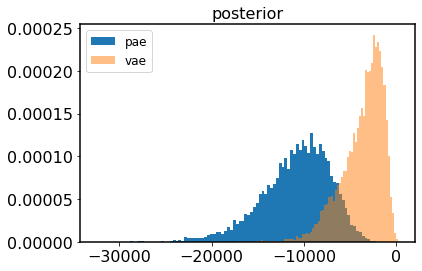

In [38]:
plt.title('posterior')
_ = plt.hist(np.mean(posteriors_pae, axis=1),bins=100,density=True,label='pae')
_ = plt.hist(np.mean(posteriors_vae, axis=1),bins=100,density=True, alpha=0.5,label='vae')
plt.legend()

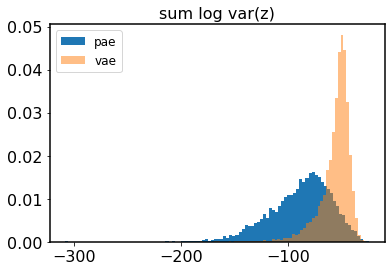

In [39]:
plt.title('sum log var(z)')
_ = plt.hist(z_var,bins=100,density=True,label='pae')
_ = plt.hist(z_var_vae,bins=100,density=True, alpha=0.5,label='vae')
plt.legend()

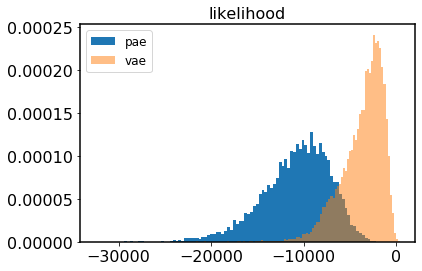

In [40]:
plt.title('likelihood')
_ = plt.hist(np.mean(likelihoods_pae, axis=1),bins=100,density=True,label='pae')
_ = plt.hist(np.mean(likelihoods_vae, axis=1),bins=100,density=True, alpha=0.5,label='vae')
plt.legend()

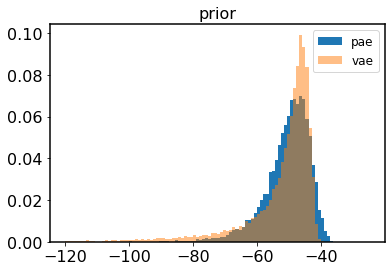

In [41]:
plt.title('prior')
_ = plt.hist(np.mean(priors_pae, axis=1),bins=100,density=True,range=(-120,-25),label='pae')
_ = plt.hist(np.mean(priors_vae, axis=1),bins=100,density=True,range=(-120,-25), alpha=0.5,label='vae')
plt.legend()

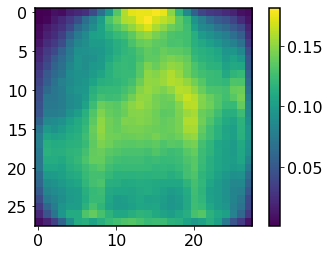

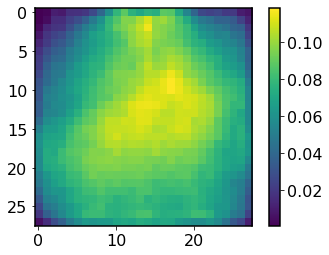

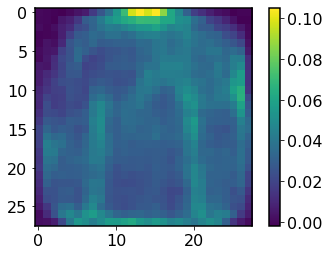

In [57]:
plt.imshow(np.squeeze(sigma_vae))
plt.colorbar()
plt.show()
plt.imshow(np.squeeze(sigma_pae))
plt.colorbar()
plt.show()
plt.imshow(np.squeeze(sigma_vae-sigma_pae))
plt.colorbar()
plt.show()


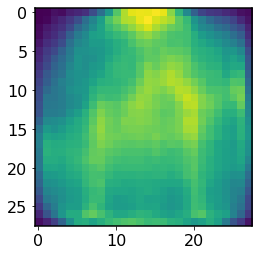

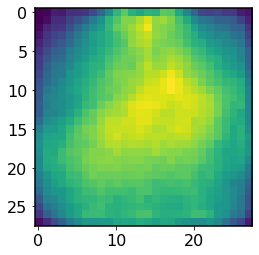

In [52]:
-np.sum(np.log(sigma_pae.flatten()**2)), -np.sum(np.log(sigma_vae.flatten()**2))

(4187.4863, 3651.7517)